In [7]:
import numpy as np
import pandas as pd
import yaml
import torch
import pickle

In [2]:
insitu = pd.read_csv('/Users/jakravit/Desktop/WaterQuality/data/Rrs_chl_matchups_polymer_v2.csv')
rrs_test = insitu.filter(regex='^[0-9]')
chl_test = insitu.chl
rrs_test.shape

(265, 81)

In [5]:
from src.de_model import DE

def load_full_model(fpath):
    model = torch.load(fpath)
    model.eval()
    return model

def read_yaml(fpath_yaml):
    yml_conf = None
    with open(fpath_yaml) as f_yaml:
        yml_conf = yaml.load(f_yaml, Loader=yaml.FullLoader)
    return yml_conf

def predict(gmm, x):
    mus, sigma_sqs = [], []
    for i in range(gmm.num_models):
        model = getattr(gmm, 'model_' + str(i))

        with torch.no_grad():
            model.eval()

        mu, sigma_sq = model(x)
        mu = mu.detach().numpy()
        sigma_sq = sigma_sq.detach().numpy()
        mus.append(mu)
        sigma_sqs.append(sigma_sq)

    mus = np.squeeze(np.array(mus))
    sigma_sqs = np.squeeze(np.array(sigma_sqs))
    mixture_mus = np.mean(mus, axis=0)
    mixture_sigmas = np.mean((sigma_sqs + mus**2), axis=0) - mixture_mus**2
    mixture_sigmas = np.sqrt(mixture_sigmas)

    return mixture_mus, mixture_sigmas

def load_from_state(fpath, mdl, n_in, batch_info, strict=False):
    n_hidden = batch_info["n_hidden"]
    num_gaussians = batch_info["num_gaussians"]
    num_lin_layers = batch_info["num_lin_layers"]
    if mdl == "mdn":
        model = MDN(n_in, n_hidden, num_gaussians, num_lin_layers)
        model.load_state_dict(torch.load(fpath[0]), strict=strict)
    else:
        model = DE(num_models=num_gaussians, inputs=n_in, hidden_layers=n_hidden, n_lin_layers=num_lin_layers)
        for i in range(len(fpath)):
            ensemble_mem = getattr(model, 'model_' + str(i))
            ensemble_mem.load_state_dict(torch.load(fpath[i]), strict=strict)
    model.eval()
    return model

In [16]:

# DE config file
conf = '/Users/jakravit/Desktop/WaterQuality/conf/hico_conf_polymer_rrs_chl_v2.yaml'
conf = read_yaml(conf)
batch_info = conf['batch_info']

# model
params=[]
ppath = '/Users/jakravit/Desktop/WaterQuality/experiments/HICO_polymer_rrs_chl_v2/model_weights/'
for p in os.listdir(ppath):
    params.append(ppath+p)
XScalerFname = '/Users/jakravit/Desktop/WaterQuality/experiments/HICO_polymer_rrs_chl_v2/x_scaler.pkl'
YScalerFname = '/Users/jakravit/Desktop/WaterQuality/experiments/HICO_polymer_rrs_chl_v2/y_scaler.pkl'
Xscaler = pickle.load(open(XScalerFname,'rb'))
Yscaler = pickle.load(open(YScalerFname,'rb'))
rrs_test_log = np.log(rrs_test)
feats_scaled = Xscaler.transform(rrs_test_log)
n_in = feats_scaled.shape[1]
model = load_from_state(params, batch_info['model'], n_in, batch_info)
x_tensor = torch.from_numpy(np.float32(feats_scaled))
y_pred, unc = predict(model, x_tensor,)
pred_unscale = Yscaler.inverse_transform(y_pred.reshape(1,-1))
chl_unlog = np.exp(pred_unscale)[0,:]
# chl = chl_unlog.reshape(feats.shape[1], feats.shape[2])

/opt/anaconda3/envs/rasterio/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


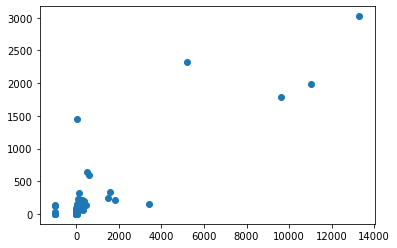

In [18]:
import matplotlib.pyplot as plt

plt.scatter(chl_test, chl_unlog)

In [ ]:
chl_unlog